Most datasets have a high number of dimensions along which the data is distributed. It is key to understand how to visualize high-dimensional datasets. This can be achieved using techniques known as dimensionality reduction. This post will focus on two techniques: PCA and t-SNE.

Firstly, let's get some high-dimensional data to work with.

## MNIST dataset

We grab the MNIST dataset using Scikit Learn.

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
X = mnist.data / 255.0
y = mnist.target

print(X.shape, y.shape)

(70000, 784) (70000,)


Then convert the matrix and vector to a *Pandas DataFrame*.

In [2]:
import pandas as pd

feat_cols = ['pixel' + str(i) for i in range(X.shape[1])]

df = pd.DataFrame(X, columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

X, y = None, None

print('Size of the DataFrame: {}'.format(df.shape))

Size of the DataFrame: (70000, 785)


To ensure randomisation, we create a random permutaion of the number 0 to 69,999.

In [4]:
rndperm = np.random.permutation(df.shape[0])

Then we generate 30 plots of randomly selected images.

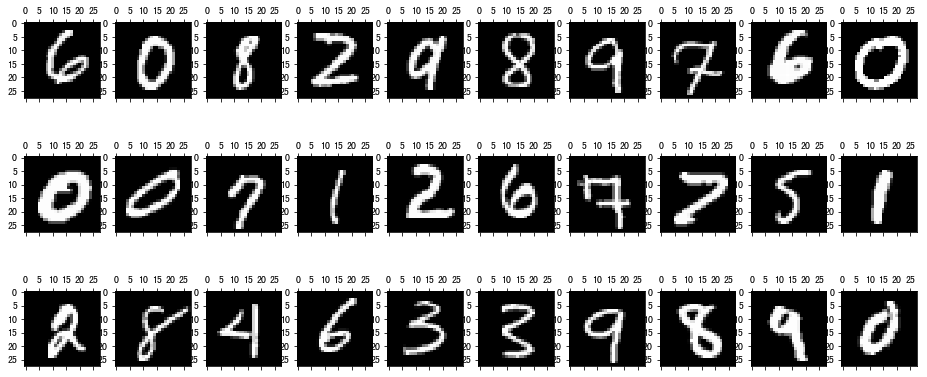

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot the graph
plt.gray()
fig = plt.figure(figsize=(16, 7))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1)
    ax.matshow(df.loc[rndperm[i], feat_cols].values.reshape((28, 28)).astype(float))

plt.show()

These images are all essentially 28-by-28 pixel images and therefore have a total of 784 dimensions, each holding the value of one specific pixel.

Let's implement dimensional reductions on this dataset.

## PCA (Principal Component Analysis)


PCA is a technique for reducing the number of dimensions in a dataset while retaining most information. 

***It is using the correlation between some dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed.***

We will use the Scikit-Learn implementation of PCA.

Since we want to plot in 2-Dimensional figure, let's start with that and generate the first two pricipal components. We will see how much of the variation in the total dataset they actually account for.

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.09746116  0.07155445]


We create a scatterplot of the first and second pricipal component and color each of the different types of digits with a different color.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


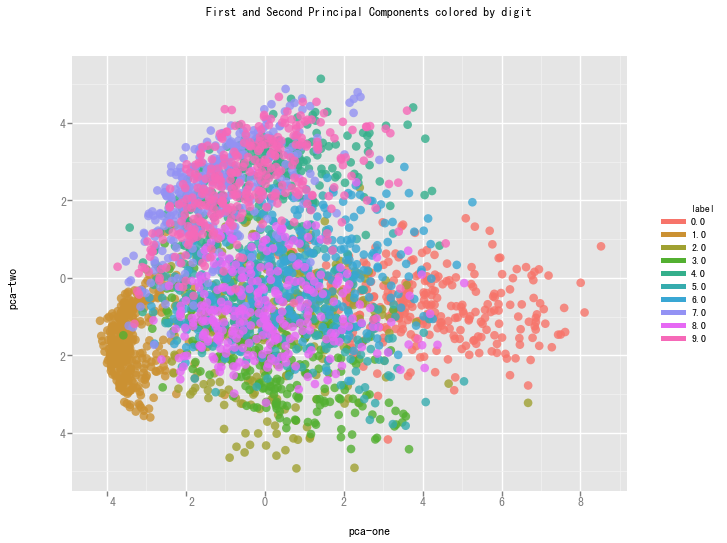

<ggplot: (291884485)>

In [11]:
from ggplot import *

chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

From the graph we can see that the two components definitely hold some information, but clearly not enough to set all of them apart.


## t-SNE (t-Distributed Stochastic Neighbouring Entities)

t-SNE is another technique for dimension reduction and is particular well suited for the visualization of high-dimensional datasets. Contrary to PCA, it is not a mathematical technique but a probablistic one. 

The [original paper](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) describes the working of t-SNE as:

> t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high.

The other key drawback is that:

> Since t-SNE scales quadratically in the number of objects N, its applicability is limited to data sets with only a few thousand input objects; beyond that, learning becomes too slow to be practical (and the memory requirements become too large).

We will use the Scikit-Learn Implementation of the algorithm in the remainder of this writeup.

Contrary to the recommendation above we will first try to run the algorithm on the actual dimensions of the data (784) and see how it does. To make sure we don’t burden our machine in terms of memory and power/time we will only use the first 7,000 samples to run the algorithm on.

In [12]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.377s...
[t-SNE] Computed neighbors for 7000 samples in 59.617s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 2.209621
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.529762
[t-SNE] Error after 300 iterations: 2.452467
t-SNE done! Time elapsed: 134.5971291065216 seconds


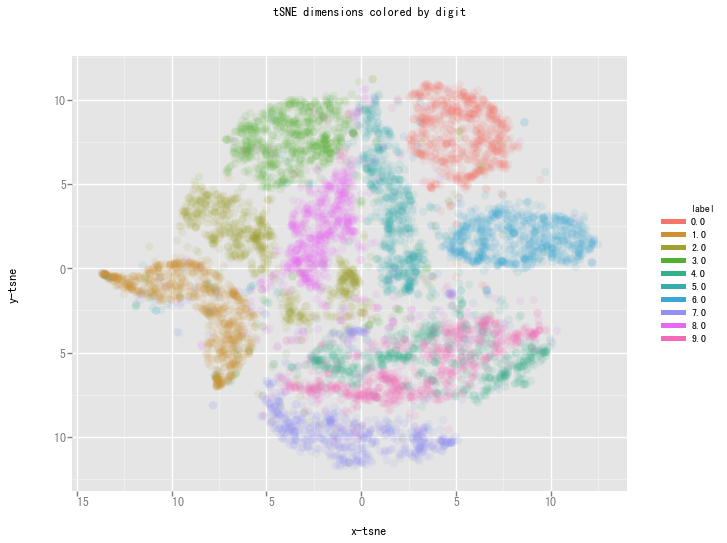

<ggplot: (-9223372036561787213)>

In [13]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

This is already a significant improvement over the PCA visualization we used earlier. We can see that the digits are very clearly clustered in their own little group.

## Reference

[Visualising high-dimensional datasets using PCA and t-SNE in Python](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

